In [1]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import hydrocyclone
import time
%load_ext mcmc
%mcmc notebook

In [2]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [3]:
scale = 1000
stim_current = 1.0

kernel_variance_mult = 1.0
kernel_ls = 0.3
conductivity_variance_mult = 1e-3 # 1e-3 is good
conductivity_ls = 0.3
run_time = 11

likelihood_variance = 0.01 # variance for the observation model - based on the value from RA paper
use_c = True

In [4]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [5]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [6]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [7]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [8]:
pattern = hydrocyclone.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [9]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

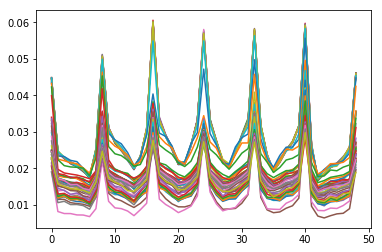

In [10]:
plt.plot(raw_data[:,1:].T);

In [11]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [12]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [13]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [14]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

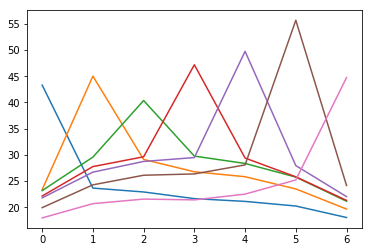

In [15]:
plt.plot(data_dict[run_time]);

# Set Up

In [16]:
from bayesian_pdes.problems import eit

In [17]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

In [18]:
def A(k):
    return sp.exp(a)*(k.diff(s_x,s_x) + k.diff(s_y,s_y) + k.diff(s_x)*a_x + k.diff(s_y)*a_y)
def A_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar,s_xbar) + k.diff(s_ybar,s_ybar) + k.diff(s_xbar)*a_x_bar + k.diff(s_ybar)*a_y_bar)
def B(k):
    return sp.exp(a)*(k.diff(s_x)*s_x + k.diff(s_y)*s_y)
def B_bar(k):
    return sp.exp(a_bar)*(k.diff(s_xbar)*s_xbar + k.diff(s_ybar)*s_ybar)

In [19]:
# Compilation is slow so don't bother unless we absolutely need to
if not use_c:
    op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
        [A, B], [A_bar, B_bar],
        kernel,
        symbols,
        parallel=False
    )

## Define the collocation grid

In [20]:
n_in_shell = 8
n_bdy = 64
n_sensor = 8
grid = hydrocyclone.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

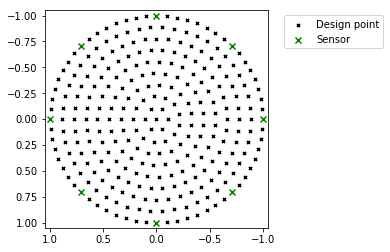

In [21]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

## Set up Proposal Matrix

In [22]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [23]:
proposal_design = hydrocyclone.grids.construct_shell(np.linspace(0,1,8))

In [24]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior_plus_boundary, grid.interior_plus_boundary],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646663081.7110291

/Users/jon/.virtualenvs/stats/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


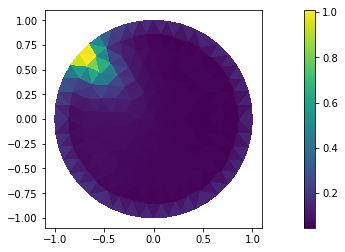

In [25]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [26]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

# Set Up The Potential

In [27]:
# todo: choose this in a more principled way
length_scale = 0.3
fun_args = np.array([kernel_ls, kernel_variance_mult])
data = data_dict[run_time] if not use_dummy_data else dummy_data


In [28]:
# choose an initial field
import scipy.optimize
def phi_const(k):
    theta = k*np.ones(proposal_cov.shape[0])
    if use_c:
        return hydrocyclone.pcn_kernel.phi_c(grid, theta, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)
    return hydrocyclone.pcn_kernel.phi(grid, op_system, theta, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)
best_const = scipy.optimize.minimize_scalar(phi_const)
kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])

In [29]:
# construct the proposal
beta = 0.2
prior_mean = best_const.x*np.ones(proposal_cov.shape[0])
sqrt_proposal_cov = np.real_if_close(linalg.sqrtm(proposal_cov))

proposal = mcmc.pcn.proposal(beta, proposal_cov, prior_mean)

if use_c:
    pcn_kernel = hydrocyclone.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)
else:
    pcn_kernel = hydrocyclone.pcn_kernel.PCNKernel(proposal, grid, op_system, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)

In [30]:
print pcn_kernel.phi(kappa_0, True)

10780.9634441


In [31]:
tmp = kappa_0.reshape((1, 177), order='F')

In [32]:
%%time
proposals, acceptances, log_likelihoods = pcn_kernel.apply(tmp, 10000, n_threads=8)
print acceptances.mean()
#print log_likelihoods.mean()

0.0279
CPU times: user 41.1 s, sys: 107 ms, total: 41.2 s
Wall time: 41.3 s


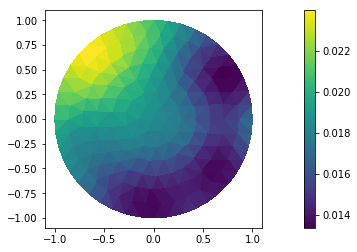

In [33]:
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(proposals[0,:]))

In [34]:
pcn_kernel.phi(proposals[-1,:], True)

5008.500382895813

# Now the SMC

In [35]:
import pandas as pd
results_dir = 'results'

In [45]:
n_particles = 8
n_iter = 10000
lamb = 100.0 # variance parameter on the temporal prior
tau = 0.0 # shift parameter on the temporal prior
s = 0.1 # interval at which time observations are collected.
beta = 0.05

In [46]:
# draw the initial sample from the prior
initial_samples = np.random.multivariate_normal(prior_mean, proposal_cov, n_particles)

In [47]:
def smc(initial_samples, kernels, resample_threshold, debug=False):
    log_weights = 1 - np.log(initial_samples.shape[0])
    weights = 1./initial_samples.shape[0]
    ess = initial_samples.shape[0] # TODO
    cur_sample = initial_samples
    
    samples = []
    for i in xrange(len(kernels)):
        # re-sample
        if ess < resample_threshold*initial_samples.shape[0]:
            print("Resampling")
            resamp_indices = np.random.choice(len(cur_sample), len(cur_sample), p=weights)
            cur_sample = np.copy(cur_sample[resamp_indices])
            log_weights = np.ones(initial_samples.shape[0]) - np.log(initial_samples.shape[0])
        
        # move
        if debug: print("Evolving particles")
        kernel = kernels[i]
        t = time.time()
        new_sample, average_acceptances, log_likelihoods = kernel.apply(cur_sample, n_iter, n_threads=8)
        taken = time.time() - t
        log_likelihoods = log_likelihoods.ravel()
        average_acceptances = average_acceptances.ravel()
        if debug: print("Done, it took {:.2f}s".format(taken))
        
        # re-weight
        last_kernel_log_likes = np.nan*np.empty(new_sample.shape[0])
        log_temporal_component = np.empty(new_sample.shape[0])
        for j in xrange(new_sample.shape[0]):
            new_samp = new_sample[j]
            if i > 0:
                last_kernel_log_likes[j] = -kernels[i-1].phi(new_samp)
            old_samp = cur_sample[j]
            delta = new_samp - old_samp
            log_temporal_component[j] = -1./(2*lamb*(s+tau))*np.dot(delta, np.dot(proposal_cov_inv, delta))

        log_spatial_component = log_likelihoods.ravel()
        if i > 0:
            log_spatial_component = log_spatial_component - last_kernel_log_likes
        
        log_weights = log_weights + log_spatial_component + log_temporal_component
        # log-sum-exp
        norm_factor = np.max(log_weights) + np.log(np.sum(np.exp(log_weights - np.max(log_weights))))
        log_weights = log_weights - norm_factor
        weights = np.exp(log_weights)
        
        output = pd.DataFrame({
            'K_i accept': average_acceptances,
            'K_i log-likelihood': log_likelihoods,
            'K_{i-1} log-likelihood': last_kernel_log_likes,
            'Spatial update': log_spatial_component,
            'Temporal update': log_temporal_component,
            'Log-weights': log_weights,
            'Weights': weights
        })
        output.to_csv(os.path.join(results_dir, '{}.csv'.format(kernel.name)))
        
        if debug: print(log_likelihoods.ravel())
        if debug: print(last_kernel_log_likes)
        if debug: print(log_spatial_component)
        if debug: print(log_temporal_component)
        if debug: print(weights)
        
        ess = np.sum(weights)**2 / np.sum(weights**2)
        print("Iter {}: Average acceptance: {}, ESS={}, Time={}".format(i, average_acceptances.mean(), ess, taken))
        
        cur_sample = new_sample
        samples.append(cur_sample)
    return samples

In [48]:
### create all the kernels
kernels = []
for i in xrange(10,20):
    data_to_use = data_dict[i]
    proposal = mcmc.pcn.proposal(beta, proposal_cov)
    
    if use_c:
        pcn_kernel = hydrocyclone.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data_to_use, fun_args, proposal_dot_mat)
    else:
        pcn_kernel = hydrocyclone.pcn_kernel.PCNKernel(proposal, grid, op_system, likelihood_variance, pattern, data_to_use, fun_args, proposal_dot_mat)
    pcn_kernel.name = 'Frame_{}'.format(i)
    kernels.append(pcn_kernel)
print len(kernels)

10


In [49]:
%%time
res, acceptances, likelihoods = kernels[1].apply(initial_samples, n_iter, n_threads=8)

CPU times: user 9min 37s, sys: 1.19 s, total: 9min 38s
Wall time: 1min 14s


In [50]:
print acceptances
print likelihoods
print np.argmax(likelihoods)

[[ 0.2547]
 [ 0.2813]
 [ 0.2571]
 [ 0.2642]
 [ 0.2459]
 [ 0.2729]
 [ 0.2841]
 [ 0.2384]]
[[-1004.78429813]
 [-1271.76194127]
 [ -850.19356297]
 [-1015.61053158]
 [ -713.80855233]
 [-1417.76111926]
 [ -696.515952  ]
 [-1119.00478561]]
6


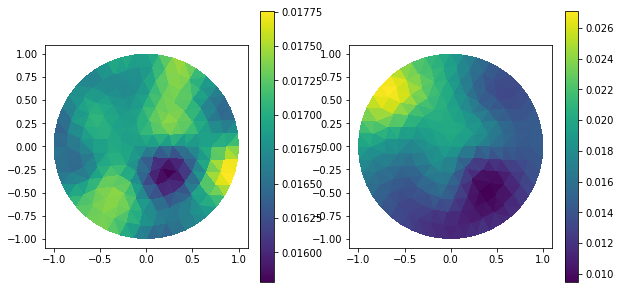

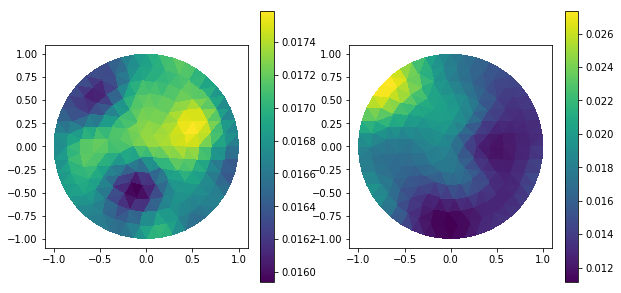

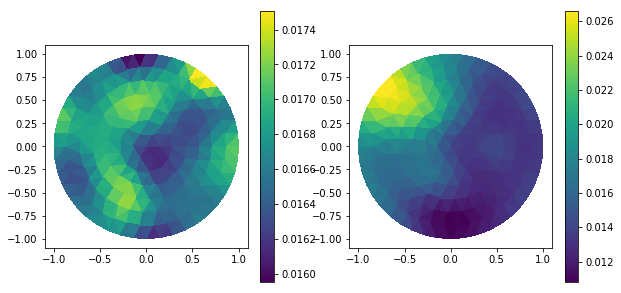

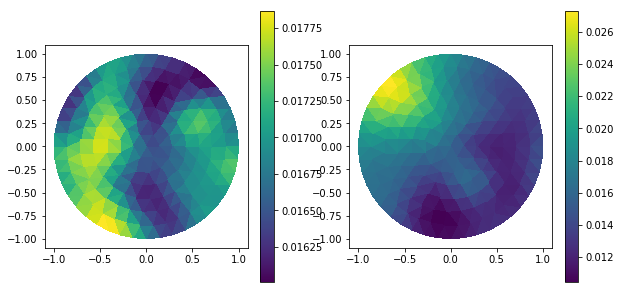

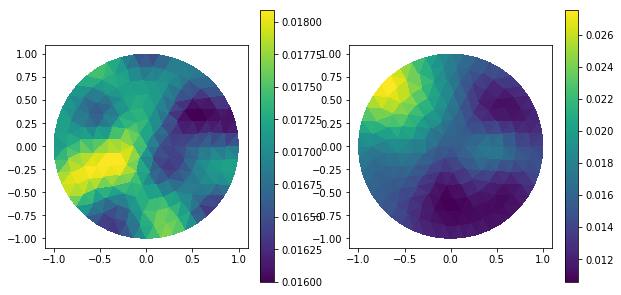

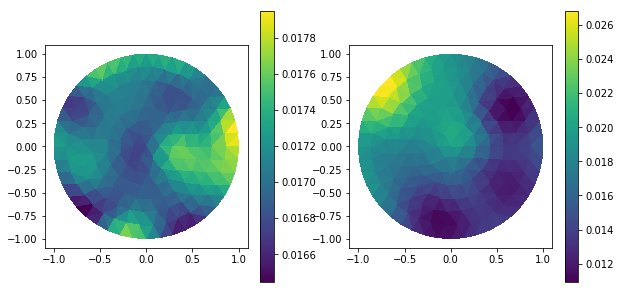

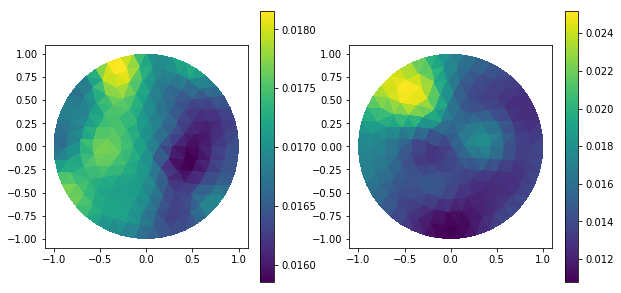

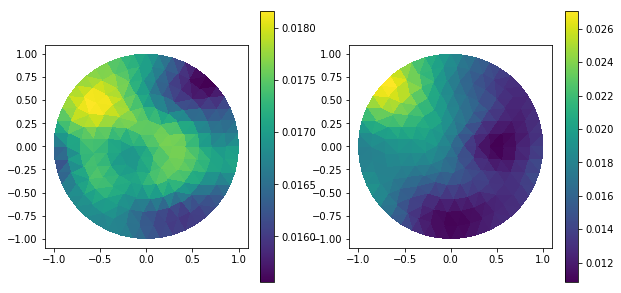

In [51]:
for i in xrange(n_particles):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(initial_samples[i,:]))
    plt.subplot(122)
    plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(res[i,:]))

In [52]:
results = smc(initial_samples, kernels, 0.5, False)

Iter 0: Average acceptance: 0.28125, ESS=1.0, Time=73.6043269634
Resampling
Iter 1: Average acceptance: 0.1387625, ESS=1.0, Time=73.656113863
Resampling
Iter 2: Average acceptance: 0.12085, ESS=1.00000044663, Time=75.3969240189
Resampling
Iter 3: Average acceptance: 0.1284, ESS=1.0, Time=78.2520008087
Resampling
Iter 4: Average acceptance: 0.1369875, ESS=1.0, Time=77.2768890858
Resampling
Iter 5: Average acceptance: 0.1586125, ESS=1.0, Time=76.6098849773
Resampling
Iter 6: Average acceptance: 0.158575, ESS=1.0, Time=76.1522009373
Resampling
Iter 7: Average acceptance: 0.173, ESS=1.0, Time=78.9150288105
Resampling
Iter 8: Average acceptance: 0.1638375, ESS=1.0, Time=76.8818309307
Resampling
Iter 9: Average acceptance: 0.154725, ESS=1.0, Time=75.9798679352


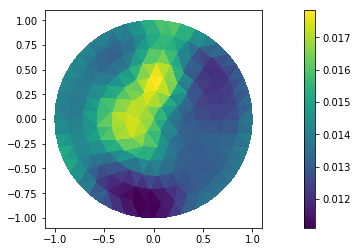

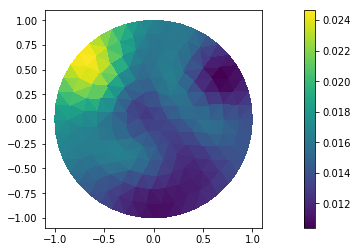

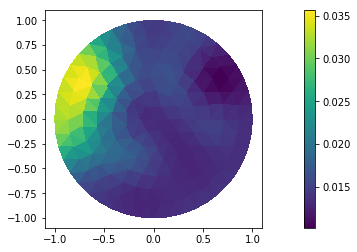

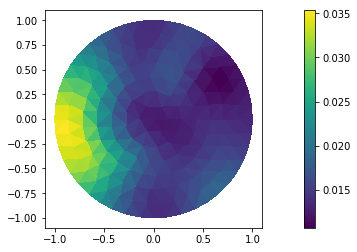

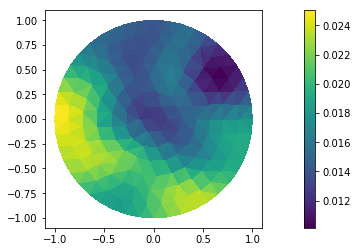

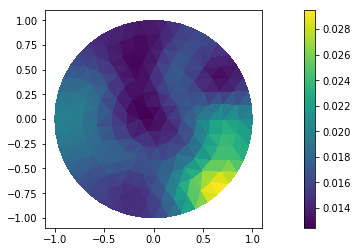

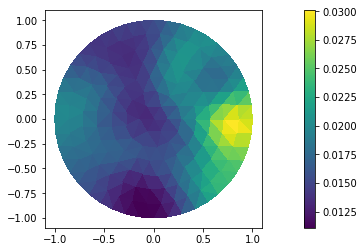

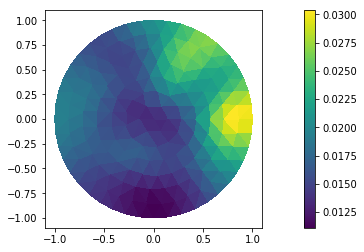

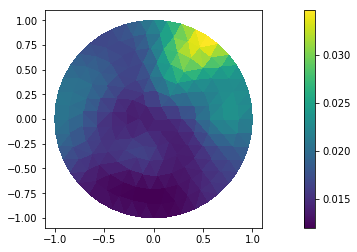

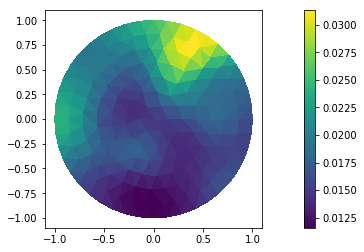

In [53]:
ix=1
for i in xrange(len(results)):
    plt.figure()
    plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(results[i][ix,:]))